In [1]:
import numpy as np
from numba import njit, prange

In [2]:
class find_mean_energy_for_1d:
    def int2array(self, x: int, L: int) -> np.ndarray:
        '''
        Takes x - number that should be represanted as array of 1 and -1, L - length of array.
        Transform number x to array of 1 and -1 by next rule: if the current last bit is 1 then leave 1 if 0 then put -1 and the same procedure goes to the next bit
        until we reached length of L.
        return array of 1 and -1 which represent spin orientation of molecules in 1d case.
        '''
        res = np.empty(L, dtype=np.int8)
        for i in range(L):
            res[i] = (x & 1) * 2 - 1
            x = x >> 1
        return res
    def energy(self, sigma: np.ndarray) -> int:
        '''
        Takes sigma - array of 1 and -1 which happens to be spin orientation of the system of molecules.
        The function treats sigma as a spin orientation of according molecules. The function calculates energy of the system of molecules with that 
        specific spin orientation.
        Return the energy of system of molecules when the spin orientation according to sigma. 
        '''
        E = 0
        n = len(sigma)
        for i in range(n):
            E -= sigma[i] * sigma[(i + 1) % n]
        return E
    def mean_energy(self, L: int, kT: np.array) -> float:
        '''
        Takes L - number of molecules, kT - the array of the products of The Boltzmann constant and temperature.
        Calculate mean energy of system with L molecules when spin orientation of the system can be represanted with 1d array.
        Return the mean energy of set of molecules with spin orientation according to sigma and with the array of
        the products of The Boltzmann constant and temperature equal to  kT.
        '''
        E_mean = 0
        Z = 0
        for sigma in prange(2**L):
            E = self.energy(int2array(sigma, L))
            e = np.exp(-E / kT)
            E_mean += E * e
            Z += e
        E_mean /= Z
        return E_mean / L
    
@njit
def energy_for_2d(sigma) -> int:
    '''
    Takes sigma - 2d array which represents spin orientation of molecules.
    energy_for_2d calculates energy for given 2D matrix which contains information about spin orientation of molecules. 
    Calculation will be done by the next formula:
    Latex style:
    -\sum_{i, j} J_{ij}(\sigma_{i, j} \sigma_{i + 1, j} + \sigma_{i, j} \sigma_{i, j + 1})
    Returns calculated energy.
    '''
    E = 0
    n = len(sigma)
    m = len(sigma[0])
    for i in prange(-1, n - 1):
        for j in prange(-1, m - 1):
            E -= (sigma[i][j] * sigma[(i + 1)][j] + sigma[i][j] * sigma[i][j + 1])
    return E


In [3]:
@njit
def calculate_mean_energy_for_2d(sigma : np.array, Lx : int, E_mean : np.array, Z : np.array, kT : float) -> np.array:
    '''
    Takes sigma - spin orientation of molecules, Lx - number of molecules in one row, E_mean - current mean energy, Z - current statistical sum, kT - the array of the product of The Boltzmann constant and temperature.   
    Calculate energy for specific set of molecules with spin orientation according to sigma.
    Returns nothing. All changings happen in-place.
    '''
    E = energy_for_2d(sigma)
    e = np.exp(-E / kT)
    Z += e
    E_mean += E * e

def mean_energy(Lx: int, Ly: int, kT: np.array) -> np.array:
    '''
    Takes Lx - number of molecules in one row, Ly - number of molecules in one column, kT -  array of  products of The Boltzmann constant and temperature
    mean_energy function contains logic for finding mean energy for 1D case and 2D case. It depends on value of Lx and Ly.
    Returns matrix of mean energies.
    '''
    i = 0
    if Lx == 1:
        res = np.empty(Ly)
        for current_kT in kT:
            res[i] = find_mean_energy_for_1d().mean_energy(Ly, current_kT)
            i += 1
        return res
    elif Ly == 1:
        res = np.empty(Lx)
        for current_kT in kT:
            res[i] = find_mean_energy_for_1d().mean_energy(Lx, current_kT)
            i += 1
        return res
    else:
        return mean_energy_for_2d(Lx, Ly, kT)
                
@njit
def mean_energy_for_2d(Lx: int, Ly : int, kT: np.array) -> np.array:
    '''
    Takes Ly - number of rows in matrix which represents spin orientation of system of molecules, 
    Lx - number of columns in matrix which represents spin orientation of system of molecules,
    kT - array of products of The Boltzmann constant and temperature.
    mean_energy_for_2d calcultate mean energy of system of Lx * Ly molecules.
    Returns calculated mean energy for each element in kT.
    '''

    Number_of_elements_in_sigma = Lx * Ly
    res = np.empty(kT.size, dtype=np.float32)
    E_mean = np.array([0.0] * kT.size)
    Z      = np.array([0.0] * kT.size)

    Number_of_rows_in_sigma = Ly
    Number_of_columns_in_sigma = Lx
    Number_of_elements_in_sigma = Number_of_rows_in_sigma * Number_of_columns_in_sigma
    for k in prange(2 ** Number_of_elements_in_sigma):
        sigma = np.empty((Number_of_rows_in_sigma, Number_of_columns_in_sigma), dtype=np.int8)
        current_number = np.int64(k)
        for index in range(Number_of_elements_in_sigma):
            if bool(current_number & 1): # If the last bit is 1
                sigma[index // Number_of_columns_in_sigma][index % Number_of_columns_in_sigma] = 1
            else:
                sigma[index // Number_of_columns_in_sigma][index % Number_of_columns_in_sigma] = -1
            current_number = current_number // 2
        calculate_mean_energy_for_2d(sigma, Lx, E_mean, Z, kT)
    E_mean /= Z
    res = E_mean / (Lx * Ly)        
    return res

In [4]:
import time
import matplotlib.pyplot as plt

#Main logic
class Main:
    def run(self, Lx_start, Lx_end, Ly, kT_range):
        '''
        Takes no arguments.
        Run calculations of mean energy for system of moleculs
        Returns nothing.
        '''
        array_of_mean_energies = np.empty(shape=(Lx_end - Lx_start, int(kT_range[-1] * 10) - int(kT_range[0] * 10) + 1))
        for Lx in range(Lx_start, Lx_end):
            start = time.perf_counter()
            array_of_mean_energies[Lx - Lx_start] = mean_energy(Lx, Ly, kT_range)
            end = time.perf_counter()
            print("Execution for Lx = " + f'{Lx}' + " took " + f'{end - start}' + ' seconds')
            print(array_of_mean_energies[Lx - Lx_start])
        np.save("new_matrix_of_mean_energies.txt", array_of_mean_energies)

In [5]:
kT_range = np.arange(1.0, 5.0, 0.1)
Ly = 4
Lx_start, Lx_end = 2, 9
main = Main()
main.run(Lx_start, Lx_end, Ly, kT_range)

Execution for Lx = 2 took 2.2535381000488997 seconds
[-1.99509474 -1.98967862 -1.98074878 -1.96731117 -1.94851445 -1.92375828
 -1.89277291 -1.85565639 -1.81286316 -1.76514762 -1.71347563 -1.65892227
 -1.60257405 -1.5454491  -1.48844224 -1.43229537 -1.3775895  -1.3247523
 -1.27407538 -1.22573609 -1.17982015 -1.13634286 -1.09526756 -1.05652101
 -1.02000562 -0.98560898 -0.9532109  -0.92268862 -0.89392045 -0.86678827
 -0.84117913 -0.8169862  -0.79410926 -0.77245486 -0.75193626 -0.73247322
 -0.71399168 -0.69642337 -0.67970548 -0.66378023]
Execution for Lx = 3 took 0.0021720000077039003 seconds
[-1.99711779 -1.99383665 -1.98825271 -1.97949351 -1.96659182 -1.94853206
 -1.92432618 -1.89312223 -1.85433583 -1.80777902 -1.75375117 -1.69305981
 -1.62695673 -1.55700043 -1.48487836 -1.41223059 -1.34050963 -1.27089443
 -1.20425882 -1.14118312 -1.08199278 -1.02680913 -0.97560137 -0.92823315
 -0.88450084 -0.84416295 -0.80696158 -0.77263715 -0.7409381  -0.71162671
 -0.68448222 -0.65930219 -0.63590256 -0

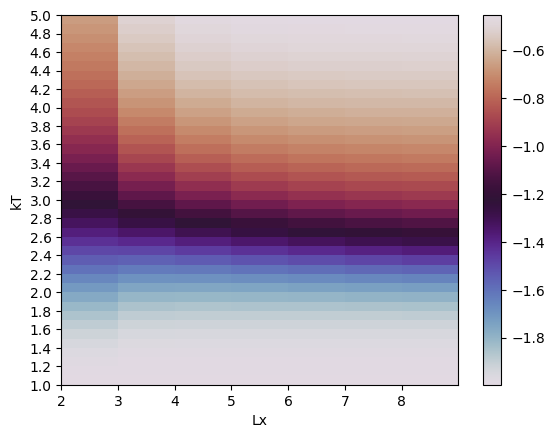

In [44]:
data = np.load("new_matrix_of_mean_energies.txt.npy")
plt.pcolormesh(np.transpose(data), cmap='twilight')

plt.xlabel('Lx')
plt.ylabel('kT')
plt.xticks(np.arange(0, 7, step=1), labels=[2 + i for i in range(7)])
plt.yticks(np.arange(0, 41, step=2), labels=[round(1.0 + 0.2 * i, 2)for i in range(21)])
plt.colorbar()
plt.show()